In [6]:
import ROOT
import sys
import numpy as np

In [7]:
numch = 32
hEgam_gate_FA = [6637,6702] # 127I
hEgam_gate_FE = [6150,6194] # 127I
hEgam_gate_FA_bkg = [6777,7044] # 127I

In [8]:
def get_det_angle (file_name: str) -> list[int]:
    """Takes a string of a root file and returns a list containing the detector map"""

    file = ROOT.TFile(file_name)
    det_pos_graph = file.Get("det_pos_graph")
    det_pos = []
    pos_angle = [-1,71,90,109,109,90,71,90,-1,71,90,109,109,90,71,90,-1,36,72,108,144,-1,-1,-1,-1,144,108,72,36,-1,-1,-1] 
    det_angle = []

    for i in range(det_pos_graph.GetN()):
        det_pos.append(int(det_pos_graph.Eval(i)))
        # print(type(det_pos_graph.Eval(i)))

    file.Close()
    
    for i in range(numch):
        det_angle.append(pos_angle[det_pos[i]])

    return det_angle

def get_hist (file_name: str, hist_name: str) -> list[ROOT.TH1]:
    """Takes a string of a root file and a name of a histogram and returns a list of histograms"""

    hist = []
    file = ROOT.TFile(file_name)
    
    for i in range(numch):
        hist.append(file.Get(f"{hist_name}/{hist_name}_d{i}"))
        hist[i].SetDirectory(0)

    file.Close()
    
    return hist

In [9]:
def calc_scale(hEgam_bkg: list[ROOT.TH1]) -> list[float]:
    """Takes a list of histograms, calculates the scale and return the scales as a list"""

    scale = []

    for i in range(numch):
        try:     
            num = hEgam_bkg[i].Integral(hEgam_bkg[i].GetXaxis().FindBin(hEgam_gate_FA[0]),hEgam_bkg[i].GetXaxis().FindBin(hEgam_gate_FA[1]))
            dem = hEgam_bkg[i].Integral(hEgam_bkg[i].GetXaxis().FindBin(hEgam_gate_FA_bkg[0]),hEgam_bkg[i].GetXaxis().FindBin(hEgam_gate_FA_bkg[1]))
            scale.append(num/dem)
        except ZeroDivisionError:
            scale.append(0)
    
    return scale


def calc_hEn_sub(hist: list, hist_bkg: list, scale: list[float]) -> list[ROOT.TH1]:
    """Takes 2 lists of histograms and a list of scales and calculates a new histogram then returns the histograms as a list"""

    hist_bkg_sub = []
    for i in range(numch):
        hist_bkg_sub.append(hist[i]-hist_bkg[i]*scale[i])
        hist_bkg_sub[i].SetDirectory(0)

    return hist_bkg_sub

In [10]:
def get_A_LH_det(hist: list[ROOT.TH1],energy: float, width: float) -> tuple[list[float], list[float]]:
    """Takes a list of histograms and returns a list of A_LH_det and its error dA_LH_det"""
    
    N_L_det = []
    N_H_det = []
    A_LH_det = []
    dA_LH_det = []
    

    for i in range(numch):
        energy_bin = hist[i].FindBin(energy)
        width_bin = int(width//hist[i].GetBinWidth(energy_bin))
        N_L_det.append(hist[i].Integral(energy_bin - width_bin, energy_bin - 1))
        N_H_det.append(hist[i].Integral(energy_bin, energy_bin + width_bin))
    
        try:     
            A_LH_det.append(calc_A_LH(N_L_det[i],N_H_det[i]))
            dA_LH_det.append(calc_dA_LH(N_L_det[i],N_H_det[i]))
        except ZeroDivisionError:
            A_LH_det.append(None)
            dA_LH_det.append(None)

    return A_LH_det, dA_LH_det


def get_A_LH_angle (hist: list[ROOT.TH1], det_angle: list[int], energy: float, width: float) -> tuple[list[float], list[float]]:
    """Takes a list of histograms and returns a list of A_LH_det and its error dA_LH_det"""

    angle_list = [36,71,72,90,108,109,144]
    N_L_angle = [0] * len(angle_list)
    N_H_angle = [0] * len(angle_list)
    A_LH_angle = [] 
    dA_LH_angle = []

    for i in range(numch):
        energy_bin = hist[i].FindBin(energy)
        width_bin = int(width//hist[i].GetBinWidth(energy_bin))
        N_L = hist[i].Integral(energy_bin - width_bin, energy_bin - 1)
        N_H  = hist[i].Integral(energy_bin, energy_bin + width_bin)

        for j in range(len(angle_list)):
            if angle_list[j] == det_angle[i]:
                N_L_angle[j] = N_L_angle[j] + N_L
                N_H_angle[j] = N_H_angle[j] + N_H

    for j in range(len(angle_list)):
        try:     
            A_LH_angle.append(calc_A_LH(N_L_angle[j],N_H_angle[j])) 
            dA_LH_angle.append(calc_dA_LH(N_L_angle[j],N_H_angle[j]))
        except ZeroDivisionError:
            A_LH_angle.append(None)
            dA_LH_angle.append(None)

    return A_LH_angle, dA_LH_angle

In [11]:
def calc_A_LH (N_L: float, N_H: float) -> float:
    """Takes two floats N_L and N_H and returns A_LH"""

    return (N_L - N_H) / (N_L + N_H)

def calc_dA_LH (N_L: float, N_H: float) -> float:
    """Takes two floats N_L and N_H and returns dA_LH"""

    return 2 * ROOT.TMath.Sqrt((N_L * N_L * N_H + N_L * N_H * N_H)) / (N_L + N_H) / (N_L + N_H)

In [12]:
def draw_hist (hist: list[ROOT.TH1]) -> None:
    """Takes a list of histograms and draws each one"""

    for i in range(len(hist)):
        # canvas.append(ROOT.TCanvas(f"hEn_d{i}", "My Graph", 800, 600))
        hist[i].Draw("E1")
        # canvas[i].Update()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


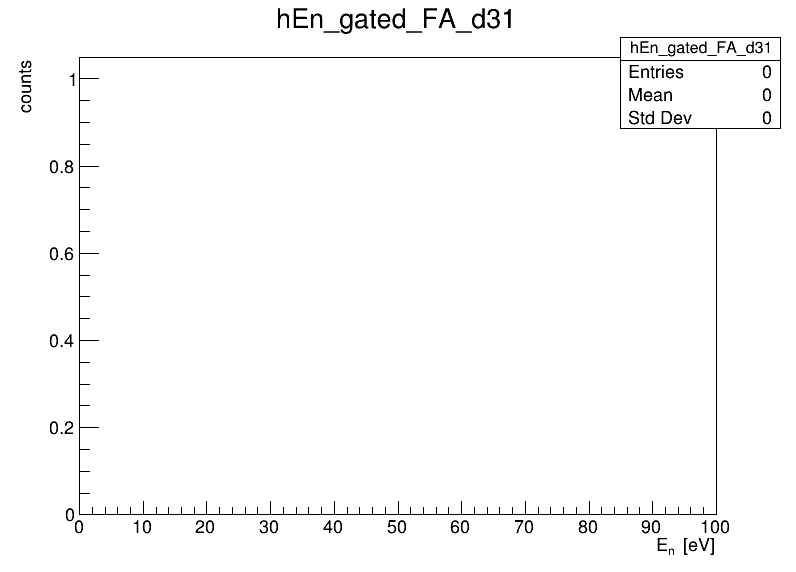

In [20]:
input_file = "stage0_output_NaI_1.root"
hEn = get_hist(input_file,"hEn_gated_FA")

# draw_hist(hEn)
c = ROOT.TCanvas("myCanvasName","The Canvas Title",800,600)
for i in hEn: 
    i.Draw("E1")
    c.Draw()
    


Warning in <TROOT::Append>: Replacing existing TH1: gauss (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: myCanvasName


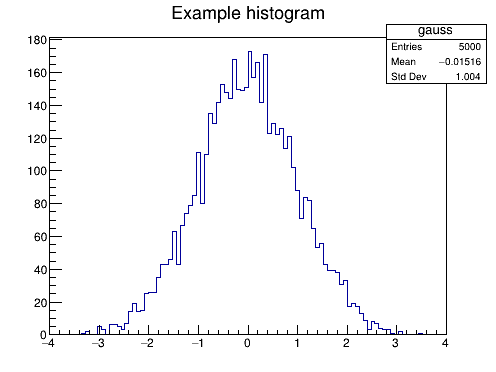

In [22]:
h = ROOT.TH1F("gauss","Example histogram",100,-4,4)
h.FillRandom("gaus")
c = ROOT.TCanvas("myCanvasName","The Canvas Title",500,400)
h.Draw()
c.Draw()